In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from PIL import Image
import math
import torch

In [2]:
def show_samples(n_samples, samples_dir, title:str) :
    n_samples_to_show = n_samples   
    sample_files = os.listdir(samples_dir)

    # Vérifie qu'il y a assez d'images
    n_samples_to_show = min(n_samples_to_show, len(sample_files))

    # Sélectionne aléatoirement les fichiers
    chosen_files = np.random.choice(sample_files, size=n_samples_to_show, replace=False)

    # ----- calcul dynamique de la grille -----
    cols = min(5, n_samples_to_show)  # max 5 par ligne
    rows = math.ceil(n_samples_to_show / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(2.2*cols, 2.2*rows))

    # Si n_samples < nb total de cases, il faut "flatten" proprement
    axes = np.atleast_1d(axes).flatten()

    for ax, file in zip(axes, chosen_files):
        img = Image.open(os.path.join(samples_dir, file)).convert("L")
        ax.imshow(img, cmap='gray')
        ax.axis('off')

    # Désactive les cases vides (si le dernier rang n’est pas complet)
    for ax in axes[len(chosen_files):]:
        ax.axis('off')

    fig.suptitle(
        title,
        fontsize=12, y=1.02
    )
    plt.tight_layout()
    plt.show()


def generate_and_show_samples(model, cluster_id=0, n_samples=25, batch_size=32, device="mps"):
    """
    Génère et affiche des échantillons d'un cluster donné du GMGAN.

    Args:
        model: modèle GeneratorGMGAN chargé
        cluster_id: index du cluster à partir duquel échantillonner (int)
        n_samples: nombre total d'images à générer
        batch_size: taille des batchs pendant la génération
        device: "cpu", "cuda" ou "mps"
    """
    model.eval()
    generated_images = []

    with torch.no_grad():
        n_generated = 0
        while n_generated < n_samples:
            # crée un batch rempli du cluster_id choisi
            z = model.sample_from_mixture(torch.full((batch_size,), cluster_id, dtype=torch.long).to(device))
            x = model(z).reshape(batch_size, 28, 28)

            # inverse normalisation si besoin (cas classique de Normalize((0.5,), (0.5,)))
            x = (x + 1) / 2
            x = torch.clamp(x, 0, 1)

            for k in range(x.shape[0]):
                if n_generated < n_samples:
                    generated_images.append(x[k].cpu())
                    n_generated += 1

    # --- Affichage dynamique en grille ---
    cols = min(5, n_samples)
    rows = math.ceil(n_samples / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(2.2 * cols, 2.2 * rows))
    axes = np.atleast_1d(axes).flatten()

    for i, ax in enumerate(axes):
        if i < len(generated_images):
            ax.imshow(generated_images[i], cmap='gray')
        ax.axis('off')

    fig.suptitle(f"From a specific cluster", fontsize=12, y=1.02)
    plt.tight_layout()
    plt.show()



def generate_grid_all_clusters(model, K, n_samples=10, batch_size=32, device="mps"):
    model.eval()

    all_imgs = []

    with torch.no_grad():
        for cluster_id in range(K):
            imgs_cluster = []
            n_generated = 0
            while n_generated < n_samples:
                z = model.sample_from_mixture(
                    torch.full((batch_size,), cluster_id, dtype=torch.long, device=device)
                )
                x = model(z).reshape(batch_size, 28, 28)
                x = (x + 1) / 2
                x = torch.clamp(x, 0, 1)

                to_take = min(batch_size, n_samples - n_generated)
                imgs_cluster.append(x[:to_take].cpu())
                n_generated += to_take

            imgs_cluster = torch.cat(imgs_cluster, dim=0)  # n_samples x 28 x 28
            all_imgs.append(imgs_cluster)

    all_imgs = torch.stack(all_imgs)  # K x n_samples x 28 x 28

    # plotting
    fig, axes = plt.subplots(K, n_samples, figsize=(1.8*n_samples, 1.8*K))
    for i in range(K):
        for j in range(n_samples):
            axes[i, j].imshow(all_imgs[i, j], cmap='gray')
            axes[i, j].axis('off')

    fig.suptitle("GMGAN clusters", y=0.99)
    plt.tight_layout()
    plt.show()


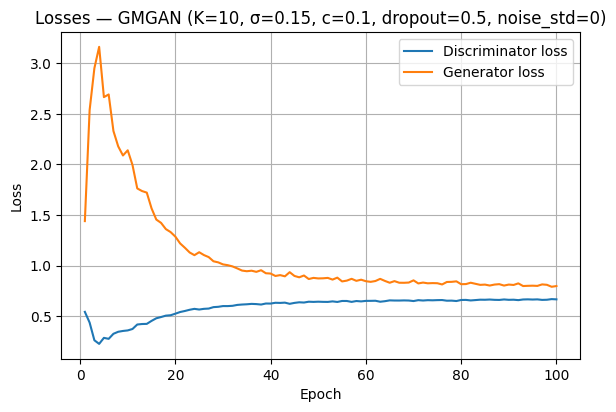

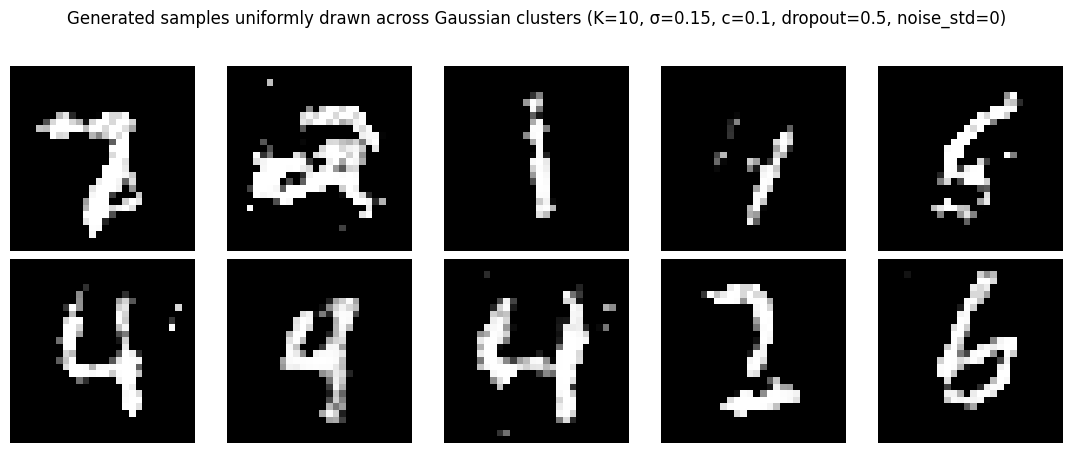

In [3]:
path_historic = '../gaussian_mixture/checkpoints/slurm/gmm_dropoutd-0.5_gaussian_noise-0_epoch-100_c-0.1_s-0.15/'
samples_dir = os.path.join(path_historic, "samples")

df_hist_1 = pd.read_csv(path_historic + 'GMGAN_2025-11-04_16-59_historic.csv')

plt.figure(figsize=(6,4))
plt.plot(df_hist_1["epoch"], df_hist_1["d_loss"], label="Discriminator loss")
plt.plot(df_hist_1["epoch"], df_hist_1["g_loss"], label="Generator loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.tight_layout()
plt.title("Losses — GMGAN (K=10, σ=0.15, c=0.1, dropout=0.5, noise_std=0)", fontsize=12)
plt.show()

show_samples(10, samples_dir, f"Generated samples uniformly drawn across Gaussian clusters (K=10, σ=0.15, c=0.1, dropout=0.5, noise_std=0)")




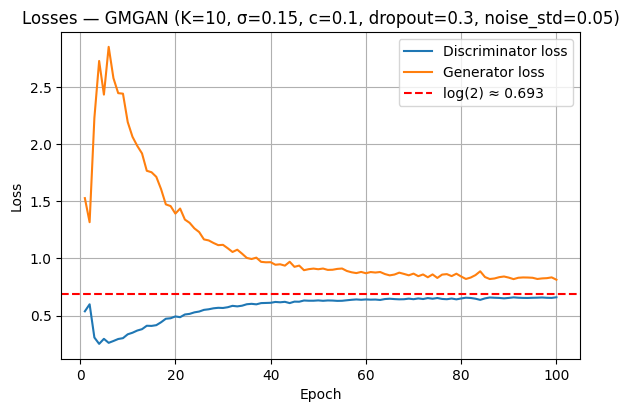

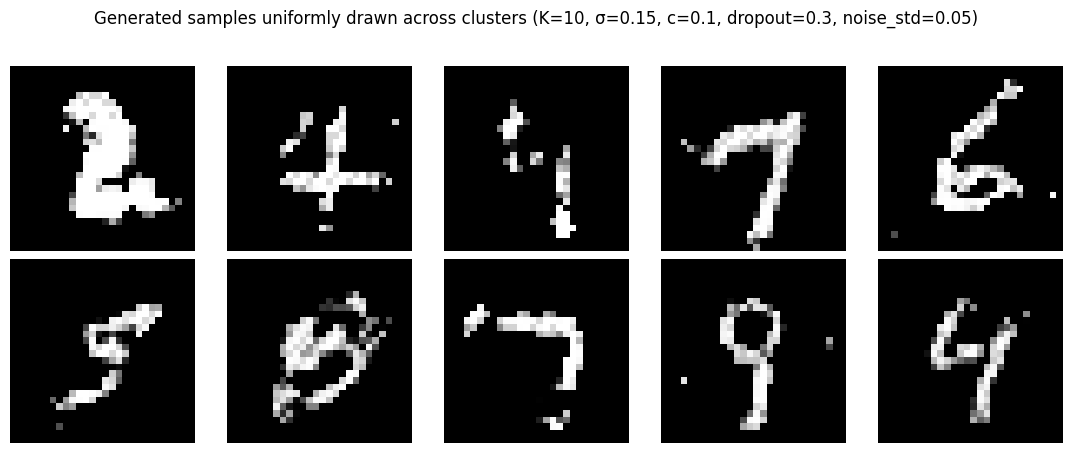

In [4]:
path_historic = '../gaussian_mixture/checkpoints/slurm/gmm_dropoutd-0.3_gaussian_noise-0.05_epoch-100_c-0.1_s-0.15/'
samples_dir = os.path.join(path_historic, "samples")

df_hist_1 = pd.read_csv(path_historic + 'GMGAN_2025-11-04_17-42_historic.csv')

plt.figure(figsize=(6,4))
plt.plot(df_hist_1["epoch"], df_hist_1["d_loss"], label="Discriminator loss")
plt.plot(df_hist_1["epoch"], df_hist_1["g_loss"], label="Generator loss")
plt.axhline(np.log(2), color='red', linestyle='--', linewidth=1.5, label='log(2) ≈ {:.3f}'.format(np.log(2)))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.tight_layout()
plt.title("Losses — GMGAN (K=10, σ=0.15, c=0.1, dropout=0.3, noise_std=0.05)", fontsize=12)
plt.show()

show_samples(10, samples_dir, f"Generated samples uniformly drawn across clusters (K=10, σ=0.15, c=0.1, dropout=0.3, noise_std=0.05)")


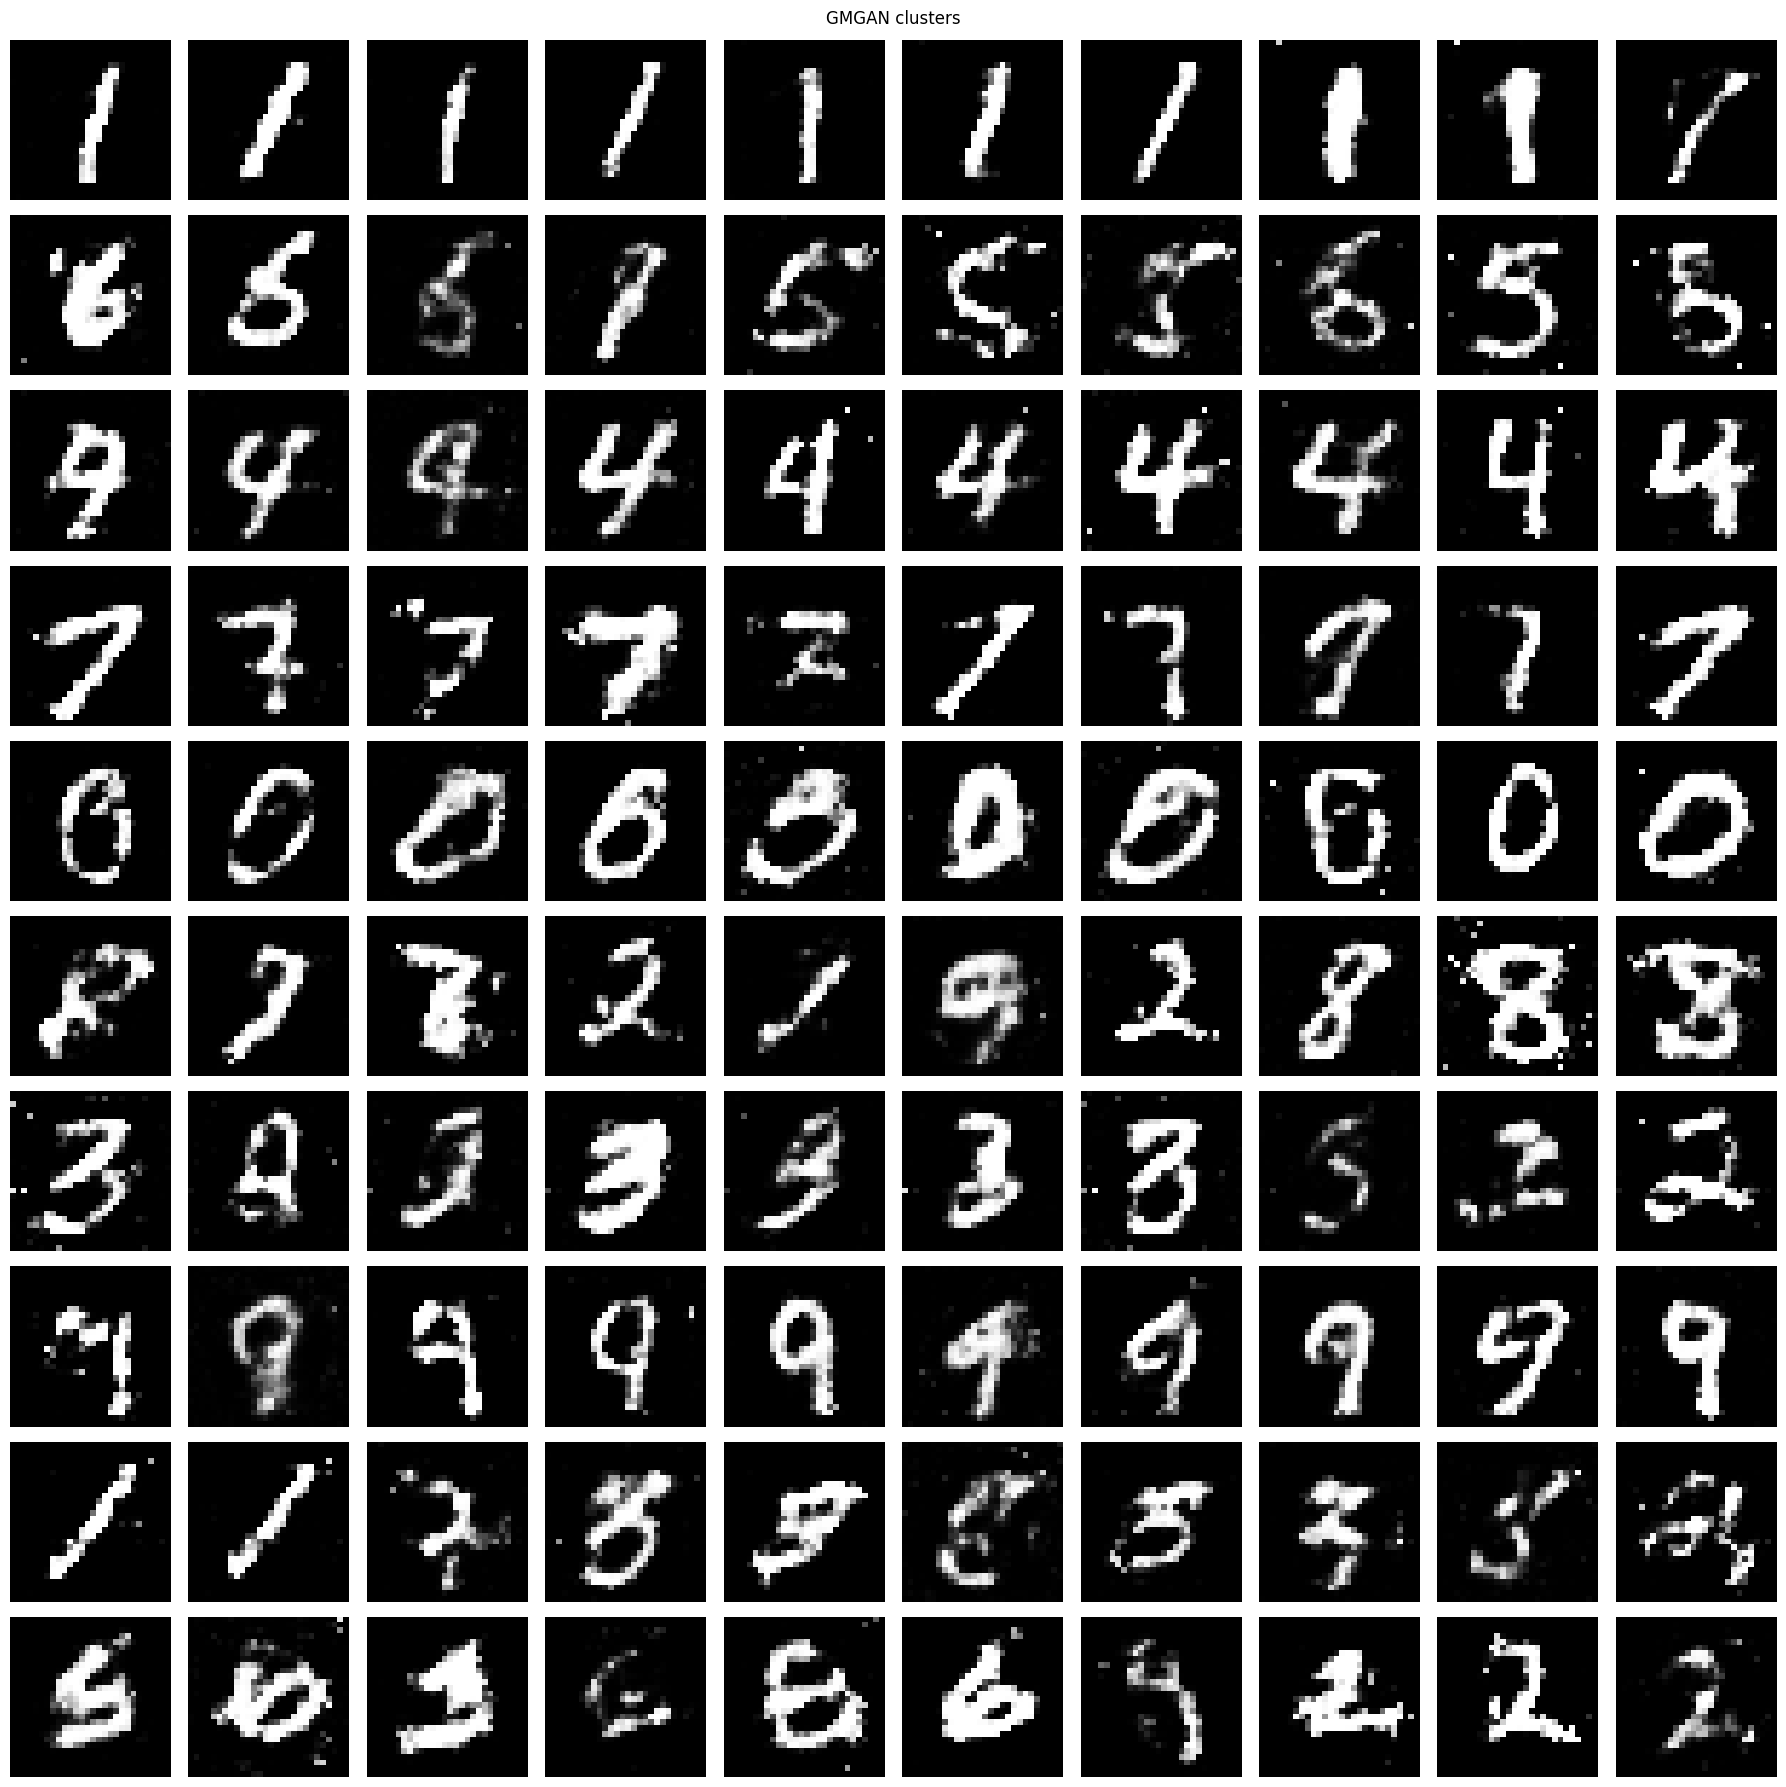

In [5]:
import sys
sys.path.append("../gaussian_mixture/")
from model import GeneratorGMGAN
import torch

checkpoint_path = path_historic + "G_GMGAN.pth"

mnist_dim = 784
latent_dim = 100
K = 10
c = 0.1
sigma = 0.15
batch_generator = 128
device="mps"

model = GeneratorGMGAN(
        g_output_dim=mnist_dim, 
        latent_space_dim=latent_dim, 
        batch_generator=batch_generator, 
        K=K, 
        c=c, 
        sigma=sigma
        ).to(device)

model.load_state_dict(torch.load(checkpoint_path, map_location=device))

generate_grid_all_clusters(model, K=10, n_samples=10, device=device)

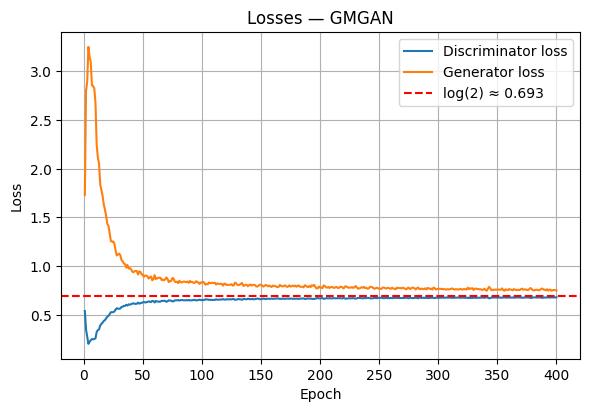

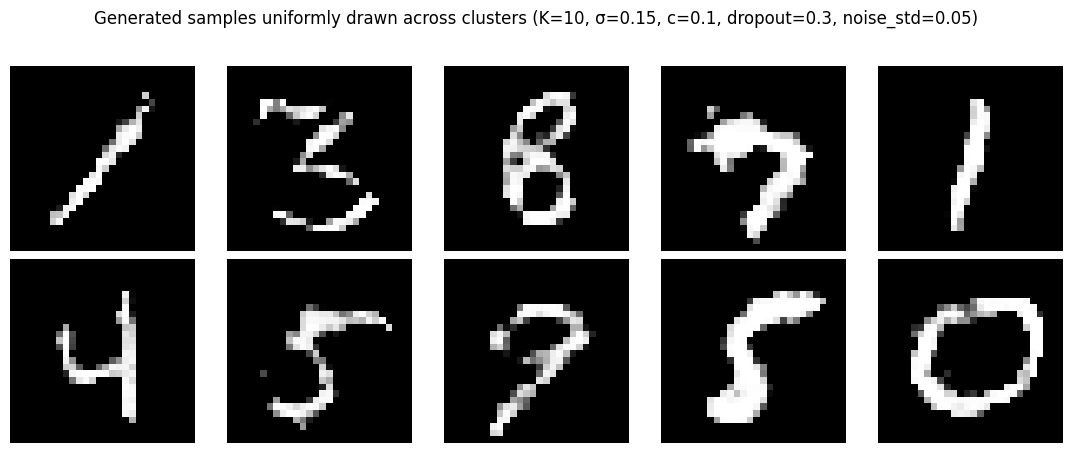

In [6]:
path_historic = '/Users/louiscarron/Documents/SCOLARITE/4A/cours/DSLab/Assignment_2/assignment2-2025-dsl/gaussian_mixture/checkpoints/slurm/gmm_ld100_K10_sig0.15_c0.1_dd0.3_lr2e-04_bd64_bg128_2025-11-14_22-18_/'
samples_dir = os.path.join(path_historic, "samples")
os.makedirs(samples_dir, exist_ok=True)

df_hist_1 = pd.read_csv(path_historic + 'historic.csv')

plt.figure(figsize=(6,4))
plt.plot(df_hist_1["epoch"], df_hist_1["d_loss"], label="Discriminator loss")
plt.plot(df_hist_1["epoch"], df_hist_1["g_loss"], label="Generator loss")
plt.axhline(np.log(2), color='red', linestyle='--', linewidth=1.5, label='log(2) ≈ {:.3f}'.format(np.log(2)))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.tight_layout()
plt.title("Losses — GMGAN", fontsize=12)
plt.show()

show_samples(10, samples_dir, f"Generated samples uniformly drawn across clusters (K=10, σ=0.15, c=0.1, dropout=0.3, noise_std=0.05)")


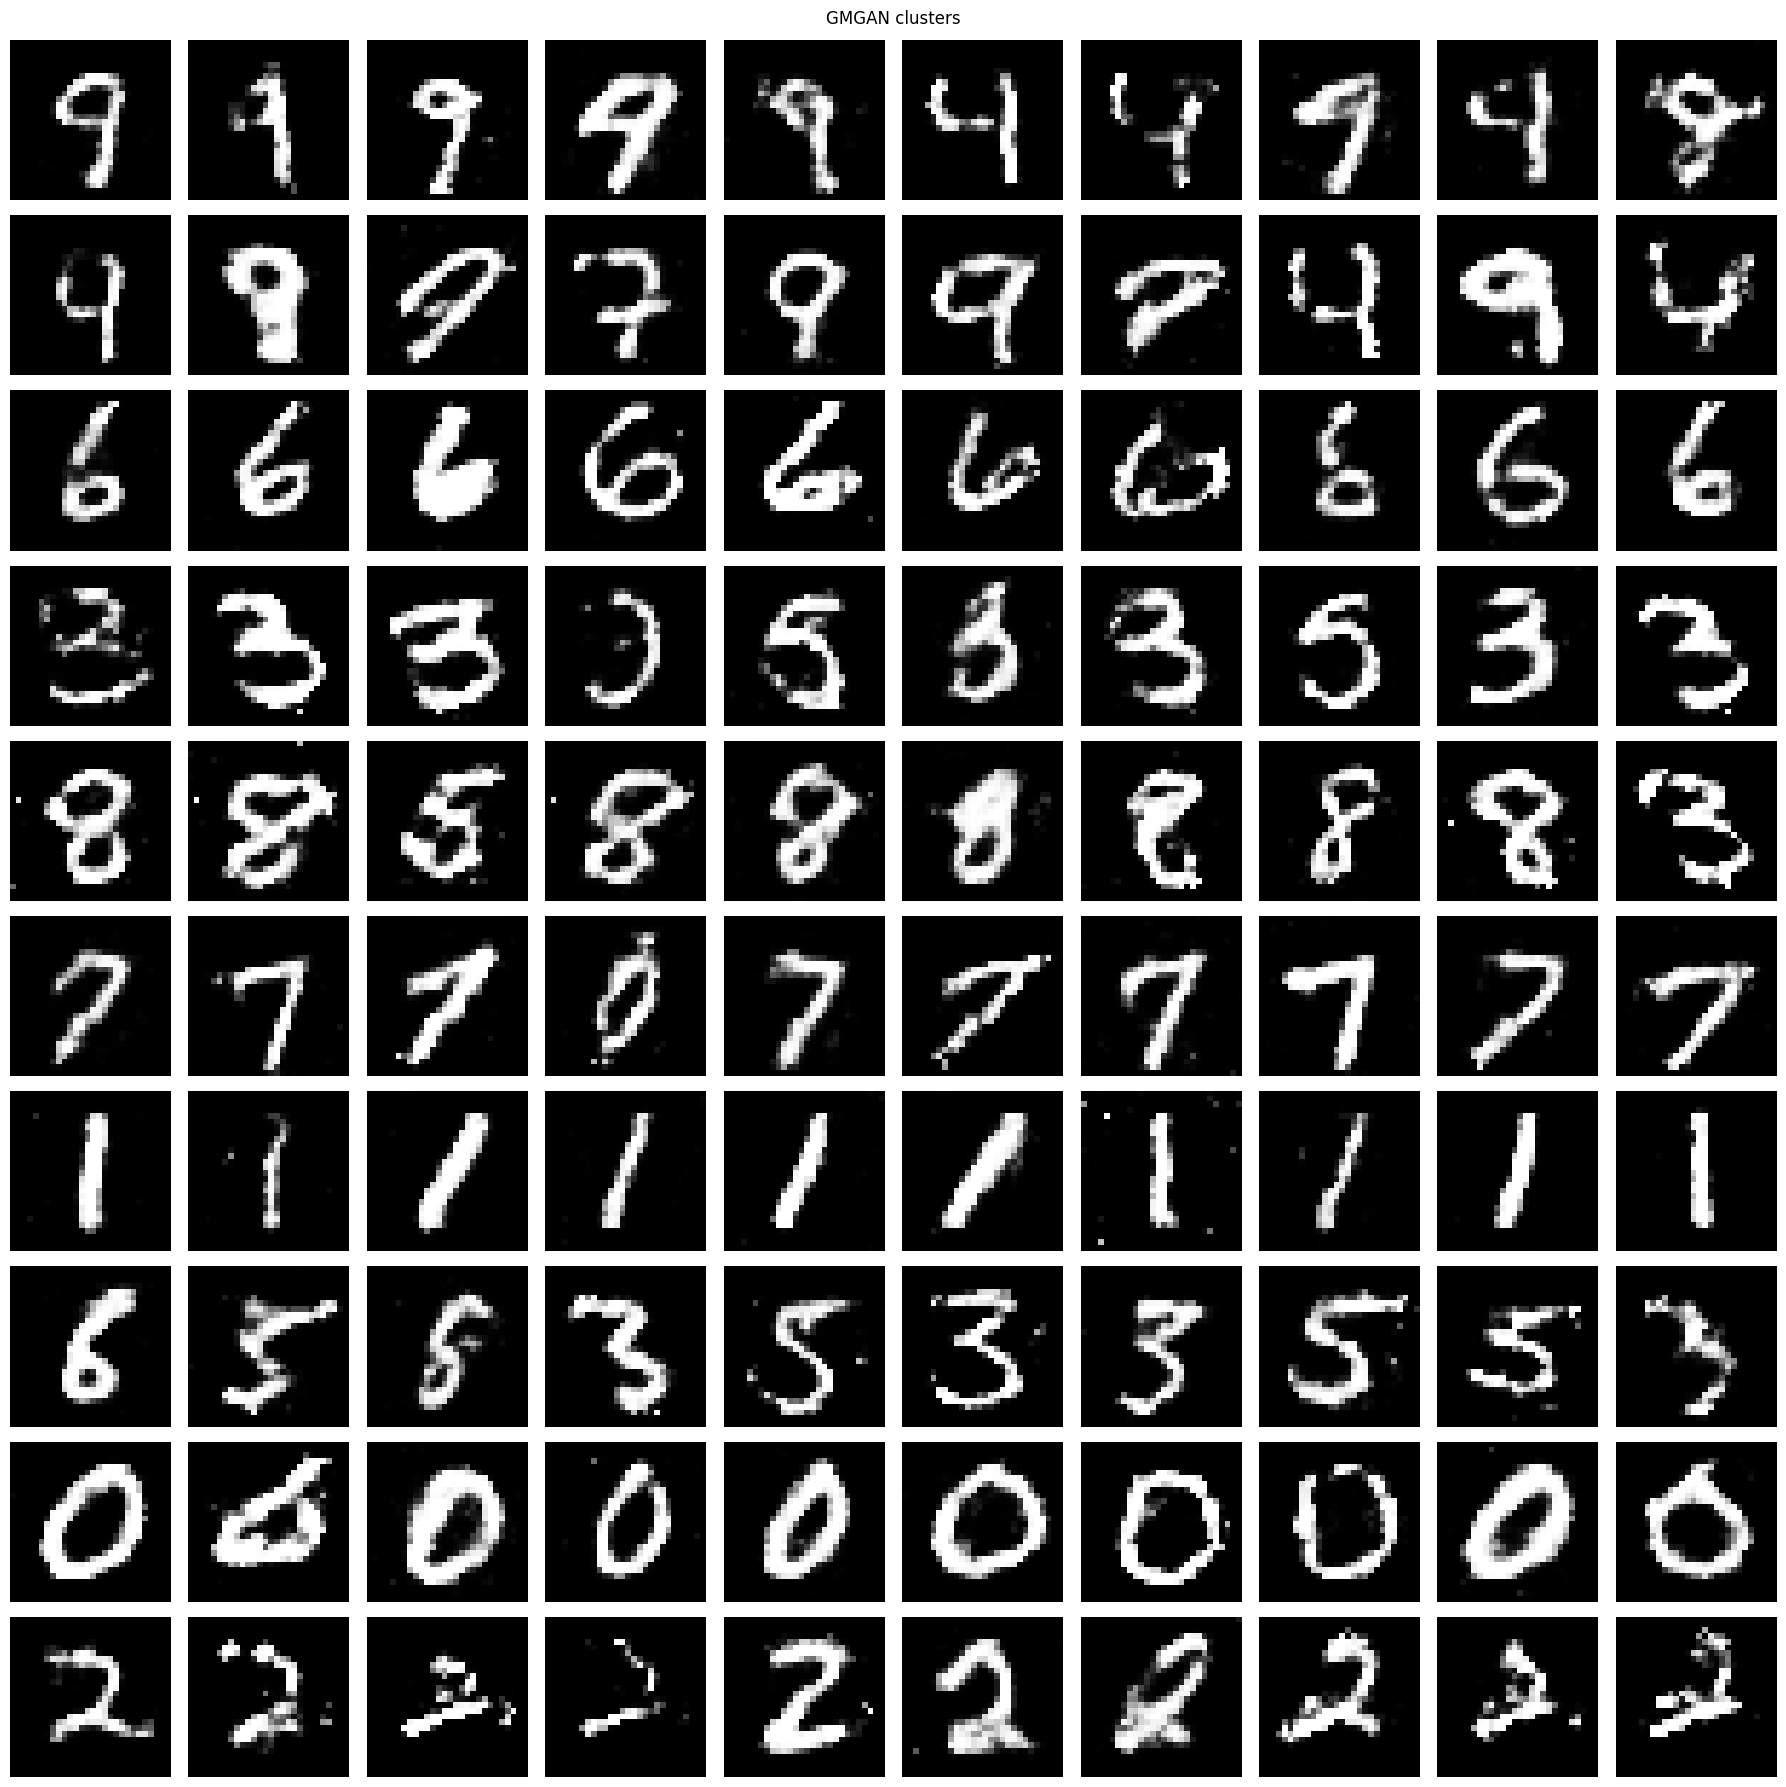

In [14]:
checkpoint_path = path_historic + "G_GMGAN.pth"

mnist_dim = 784
latent_dim = 100
K = 10
c = 0.1
sigma = 0.15
batch_generator = 128
device="mps"

model = GeneratorGMGAN(
        g_output_dim=mnist_dim, 
        latent_space_dim=latent_dim, 
        batch_generator=batch_generator, 
        K=K, 
        c=c, 
        sigma=sigma
        ).to(device)

model.load_state_dict(torch.load(checkpoint_path, map_location=device))

generate_grid_all_clusters(model, K=10, n_samples=10, device=device)

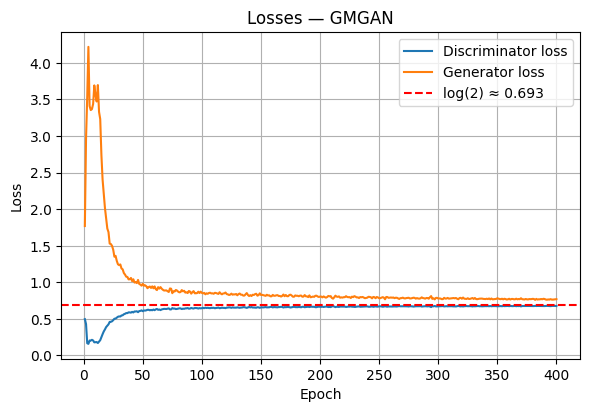

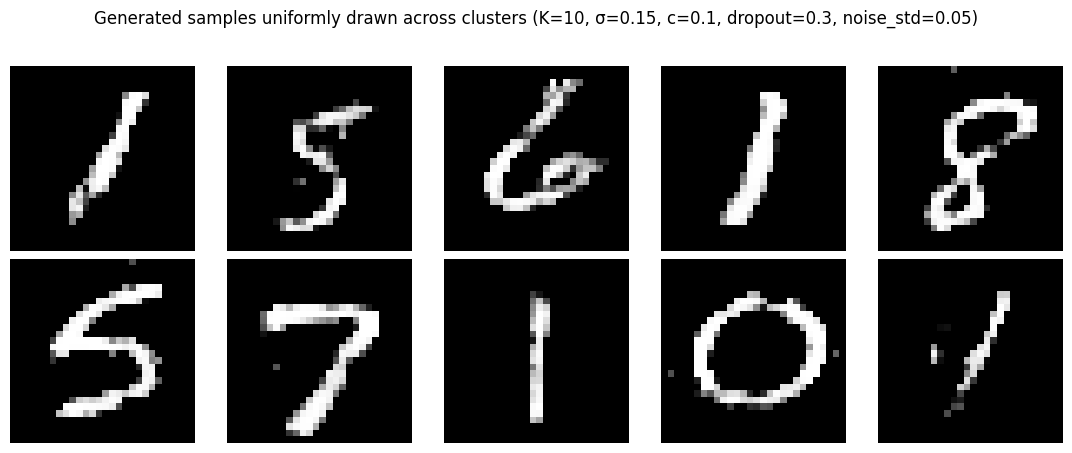

In [20]:
path_historic = '/Users/louiscarron/Documents/SCOLARITE/4A/cours/DSLab/Assignment_2/assignment2-2025-dsl/gaussian_mixture/checkpoints/slurm/gmm_ld100_K10_sig0.1_c0.1_dd0.3_lr2e-04_bd64_bg128_2025-11-14_23-41_/'
samples_dir = os.path.join(path_historic, "samples")
os.makedirs(samples_dir, exist_ok=True)

df_hist_1 = pd.read_csv(path_historic + 'historic.csv')

plt.figure(figsize=(6,4))
plt.plot(df_hist_1["epoch"], df_hist_1["d_loss"], label="Discriminator loss")
plt.plot(df_hist_1["epoch"], df_hist_1["g_loss"], label="Generator loss")
plt.axhline(np.log(2), color='red', linestyle='--', linewidth=1.5, label='log(2) ≈ {:.3f}'.format(np.log(2)))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.tight_layout()
plt.title("Losses — GMGAN", fontsize=12)
plt.show()

show_samples(10, samples_dir, f"Generated samples uniformly drawn across clusters (K=10, σ=0.15, c=0.1, dropout=0.3, noise_std=0.05)")


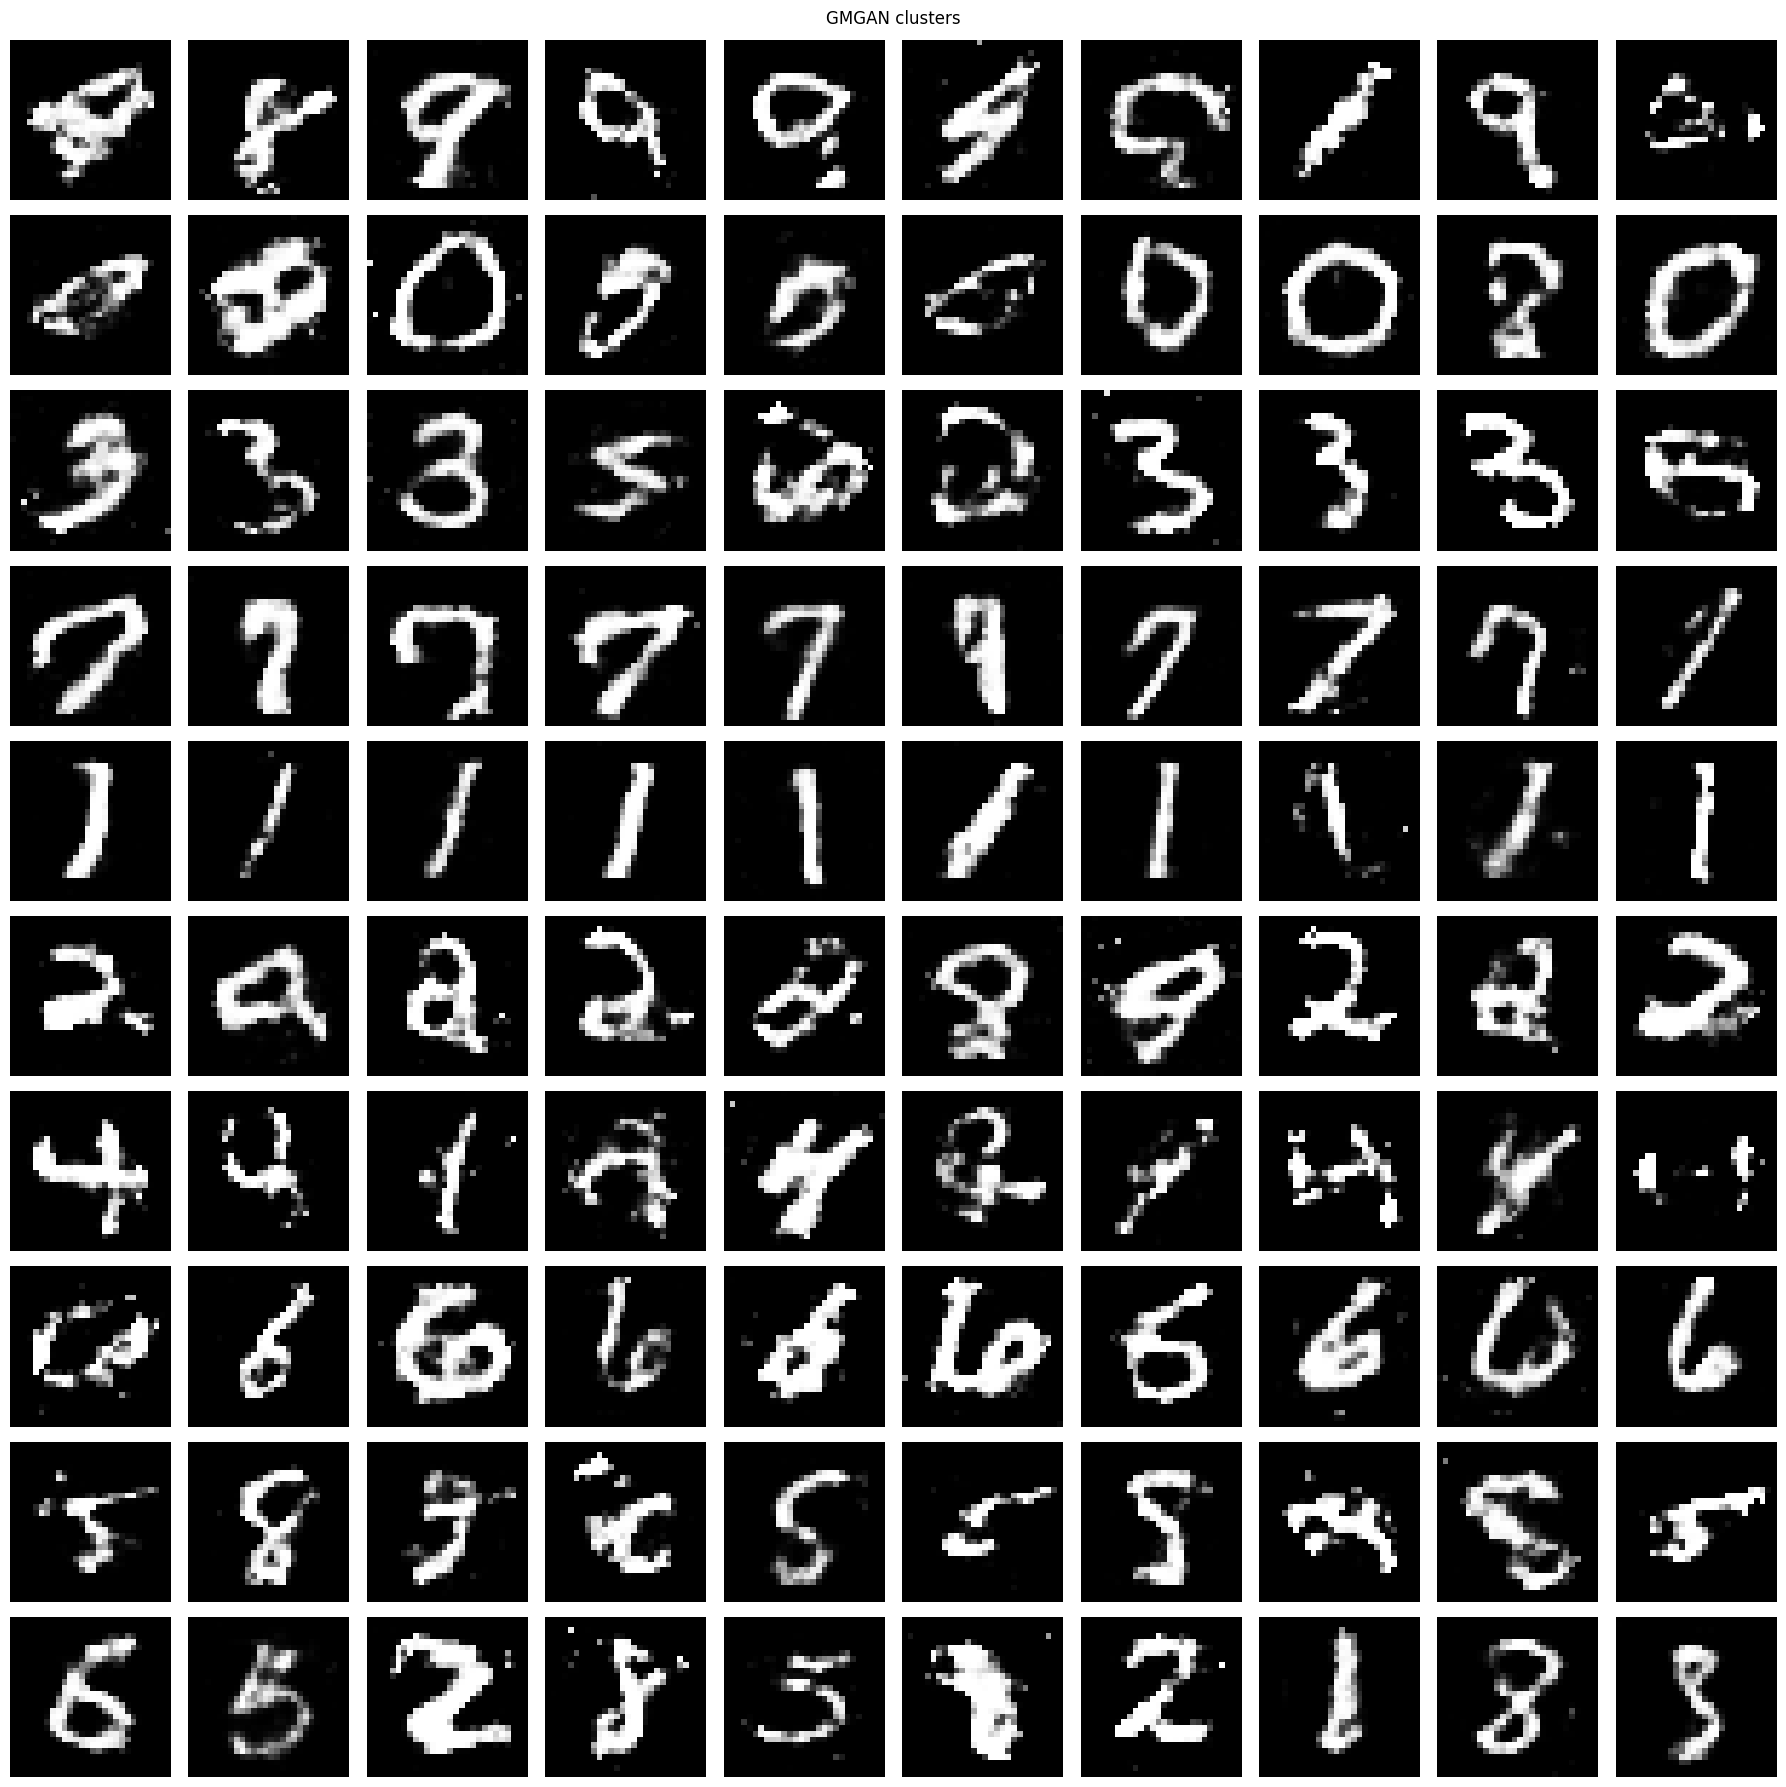

In [21]:
checkpoint_path = path_historic + "G_GMGAN.pth"

mnist_dim = 784
latent_dim = 100
K = 10
c = 0.1
sigma = 0.15
batch_generator = 128
device="mps"

model = GeneratorGMGAN(
        g_output_dim=mnist_dim, 
        latent_space_dim=latent_dim, 
        batch_generator=batch_generator, 
        K=K, 
        c=c, 
        sigma=sigma
        ).to(device)

model.load_state_dict(torch.load(checkpoint_path, map_location=device))

generate_grid_all_clusters(model, K=10, n_samples=10, device=device)

In [8]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

def test_gaussian_noise(sigma=0.1):
    # Load 1 MNIST sample
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5,), std=(0.5,))
    ])

    dataset = datasets.MNIST(root="../data", train=True, download=True, transform=transform)
    
    x, _ = dataset[0]  # image (1, 28, 28)
    x = x.view(-1)     # flatten to 784

    # Apply gaussian noise
    noise = sigma * torch.randn_like(x)
    x_noisy = x + noise

    # Reshape for display
    x_img = x.view(28, 28)
    x_noisy_img = x_noisy.view(28, 28)

    # Compute RMS difference
    rms = torch.sqrt(torch.mean((x_noisy - x)**2)).item()

    print(f"Sigma = {sigma} → RMS noise = {rms:.4f}")

    # Plot
    fig, axs = plt.subplots(1, 2, figsize=(6, 3))
    axs[0].imshow(x_img, cmap='gray')
    axs[0].set_title("Original")
    axs[0].axis('off')

    axs[1].imshow(x_noisy_img, cmap='gray')
    axs[1].set_title(f"Noisy (σ={sigma})")
    axs[1].axis('off')

    plt.show()

Sigma = 0.01 → RMS noise = 0.0102


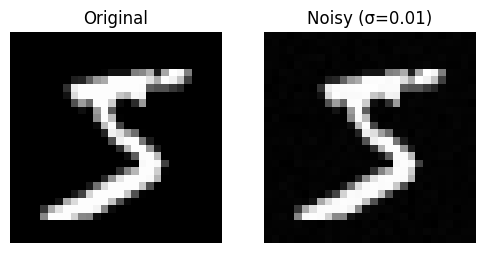

Sigma = 0.05 → RMS noise = 0.0513


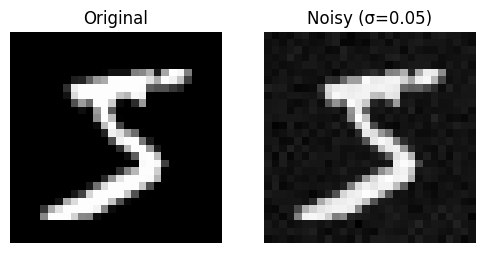

Sigma = 0.1 → RMS noise = 0.0982


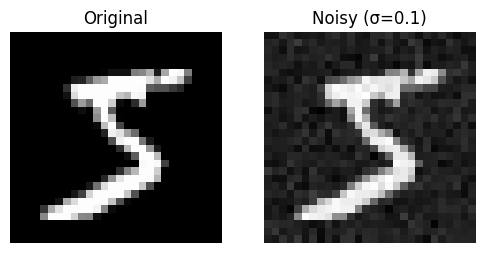

Sigma = 0.2 → RMS noise = 0.1958


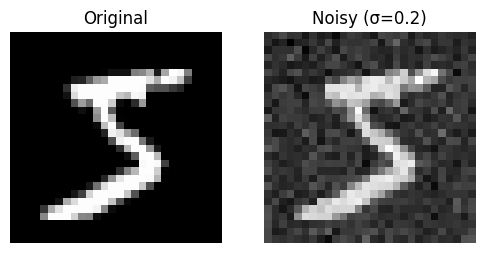

In [9]:
for sigma in [0.01, 0.05, 0.1, 0.2]:
    test_gaussian_noise(sigma)

In [2]:
import torch
path_historic = '/Users/louiscarron/Documents/SCOLARITE/4A/cours/DSLab/Assignment_2/repo/assignment2-2025-dsl/gaussian_mixture/checkpoints/slurm/gmm_ld100_K10_sig0.1_c0.1_dd0.3_lr2e-04_bd64_bg128_2025-11-15_00-30_/'
checkpoint_path = path_historic + "G_GMGAN.pth"

mnist_dim = 784
latent_dim = 100
K = 10
c = 0.1
sigma = 0.1
batch_generator = 128
device="mps"

loaded = torch.load(checkpoint_path, map_location=device)

vanilla_keys = [k for k in loaded.keys() if k.startswith("fc")]
vanilla_state_dict = {k: loaded[k] for k in vanilla_keys}

mixture_state_dict = {"mu_clusters": loaded["mu_clusters"]}
#mixture_state_dict["sigma_clusters"] = loaded["sigma_clusters"]

torch.save(vanilla_state_dict, "GM_vanilla.pth")
torch.save(mixture_state_dict, "mu_clusters.pth")

In [ ]:
loaded = torch.load(checkpoint_path, map_location=device)
print(loaded.keys())

odict_keys(['mu_clusters', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias', 'fc4.weight', 'fc4.bias'])
